In [26]:
import tensorflow as tf 
import numpy as np
import os
from scipy.ndimage import imread
import matplotlib.colors as cl
import Shared
from tqdm import tqdm
Shared.select_gpu(3)

In [2]:
import tensorflow.contrib.distributions as tf_dist

In [3]:
tf.__version__

'0.11.0rc2'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [5]:
data = np.loadtxt("Skin_NonSkin.txt", delimiter="\t", unpack=False)
print("Loaded Data from textfile ...")

Skin = list(filter(lambda e: e[3]==1, data))
NonSkin = list(filter(lambda e: e[3]==2, data))
print("Filtered Data into Skin/NonSkin ...")

X_Skin = np.array(Skin)
X_NonSkin = np.array(NonSkin)

trSkin = int(round(len(Skin)*1.0))
trNonSkin = int(round(len(NonSkin)*1.0))

Train_Skin = Skin[:trSkin]
Test_Skin = Skin[trSkin:]
Train_NonSkin = NonSkin[:trNonSkin]
Test_NonSkin = NonSkin[trNonSkin:]

Loaded Data from textfile ...
Filtered Data into Skin/NonSkin ...


In [6]:
COMP = [2,1,0] # RGB
# COMP = [2,1] # RG
# COMP = [1,0] # GB

In [7]:
X = tf.placeholder(tf.float32, shape=(None, len(COMP)), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

def ClassDistribution(scope):
    with tf.name_scope(scope):
        X = tf.placeholder(tf.float32, shape=(None, len(COMP)), name="X")
        sample_size = tf.cast(tf.shape(X)[0], dtype=tf.float32, name="sample_size")
        Mu = tf.reduce_mean(X, 0, name="Mu")
        X_norm = tf.sub(X, Mu, name="X_norm")
        Sigma = tf.div(tf.matmul(tf.transpose(X_norm), X_norm, name="Sigma"), sample_size)
        Dist = tf_dist.MultivariateNormalFull(Mu, Sigma, name="Dist")
        
        return {
            'X': X,
            'SampleSize': sample_size,
            'Mu': Mu,
            'Sigma': Sigma,
            'X_Normalized': X_norm,
            'Dist': Dist
        }

Skin = ClassDistribution("Skin")
NonSkin = ClassDistribution("NonSkin")

Pdf_Skin = Skin['Dist'].pdf(X)
Pdf_NonSkin = NonSkin['Dist'].pdf(X)
Tot_Pdf = Pdf_Skin + Pdf_NonSkin

Prob_Skin = Pdf_Skin / Tot_Pdf
Prob_NonSkin = Pdf_NonSkin / Tot_Pdf

Pred = Prob_NonSkin # as Label(NonSkin) = 1, Label(Skin) = 0
correct_prediction = tf.equal(tf.round(Pred), y)
Accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
import DistractedDriver as dd
_X, _y, _Xt, _yt = dd.load_data(True)

#### Classifier Training

In [9]:
with tf.Session() as sess:
    Skin_Mu, Skin_Sigma, NonSkin_Mu, NonSkin_Sigma = sess.run([
            Skin['Mu'], Skin['Sigma'], NonSkin['Mu'], NonSkin['Sigma']
        ], feed_dict={
            Skin['X']: cl.rgb_to_hsv(X_Skin[:, [2,1,0]]),
            NonSkin['X']: cl.rgb_to_hsv(X_NonSkin[:, [2,1,0]])
        })

#### Scoring Function

In [13]:
from ipywidgets import widgets
from scipy.ndimage.measurements import label, labeled_comprehension

In [29]:
def process_image(fltr, img, threshold):
    lbl, nlbl = label(fltr > threshold)
    lbls = np.arange(1, nlbl+1)
    objs = labeled_comprehension(fltr, lbl, lbls, np.count_nonzero, int, 0)
    main_objs = np.arange(0, objs.shape[0])[objs>1]
    score = main_objs.sum()
    top_3_lbls = reduce(lambda prev, curr: prev + (lbl == curr+1).astype(int), main_objs, np.zeros(lbl.shape))
    img_w_lbls = np.where(top_3_lbls[:,:, np.newaxis].astype(np.bool), img, np.zeros(img.shape)).astype(np.uint8)
    return lbl, nlbl, objs, main_objs, score, top_3_lbls, img_w_lbls

In [ ]:
def plot_dec(idx, threshold):
#     structure=np.ones((3,3))
    lbl, nlbl, objs, main_objs, score, top_3_lbls, img_w_lbls = process_image(
        fltrs[idx], images[idx], threshold
    )
    
    fig, axes = plt.subplots(1,3, figsize=(10,10))
    axes[0].set_title("Objs: {} - Score: {:.4f}".format(nlbl, score))
    axes[0].imshow(lbl)
    axes[0].axis('off')
    axes[1].imshow(top_3_lbls)
    axes[1].axis('off')
    axes[2].imshow(img_w_lbls)
    axes[2].axis('off')
    
widgets.interact(plot_dec, threshold=(0,1,0.01), idx=(0,fltrs.shape[0]-1, 1))

#### Image Segmentation

In [30]:
def segment_images(images, batch_size=20, threshold=0.5):
    fltrs = np.zeros(images.shape[:3])
    top_3_fltrs = np.zeros(images.shape[:3])
    images_segmented = np.zeros(images.shape)
    
    count = images.shape[0]
    batches = range(0, count, batch_size) + [count]
    with tf.Session() as sess:
        try:
            pbar = tqdm(total=count)
            for start, end in zip(batches[:-1], batches[1:]):
                fltrs[start:end] = sess.run(Prob_Skin, feed_dict={
                        X: cl.rgb_to_hsv(images[start:end]).reshape((-1, 3)),
                        Skin['Mu']: Skin_Mu,
                        Skin['Sigma']: Skin_Sigma,
                        NonSkin['Mu']: NonSkin_Mu,
                        NonSkin['Sigma']: NonSkin_Sigma
                    }).reshape((-1, 299, 299))

                for i in range(start, end):
                    lbl, nlbl, objs, main_objs, score, top_3_lbls, img_w_lbls = process_image(
                        fltrs[i], images[i], threshold
                    )
                    top_3_fltrs[i] = top_3_lbls
                    images_segmented[i] = img_w_lbls
                
                pbar.update(end-start)
        finally:
            pbar.close()
            
    return fltrs, top_3_fltrs, images_segmented

In [31]:
fltrs, fltrs_smoothed, images_segmented = segment_images(_X, batch_size=50)





  0%|          | 0/12977 [00:00<?, ?it/s]



  0%|          | 1/12977 [00:01<3:45:03,  1.04s/it]



  0%|          | 6/12977 [00:01<2:39:08,  1.36it/s]



  0%|          | 9/12977 [00:01<1:53:33,  1.90it/s]



  0%|          | 14/12977 [00:01<1:20:48,  2.67it/s]



  0%|          | 18/12977 [00:01<58:28,  3.69it/s]  



  0%|          | 22/12977 [00:01<42:49,  5.04it/s]



  0%|          | 26/12977 [00:01<31:39,  6.82it/s]



  0%|          | 30/12977 [00:01<25:07,  8.59it/s]



  0%|          | 33/12977 [00:02<20:19, 10.62it/s]



  0%|          | 37/12977 [00:02<16:15, 13.26it/s]



  0%|          | 43/12977 [00:02<12:37, 17.08it/s]



  0%|          | 47/12977 [00:02<10:32, 20.46it/s]






  0%|          | 51/12977 [00:03<22:26,  9.60it/s]



  0%|          | 54/12977 [00:03<18:14, 11.80it/s]



  0%|          | 57/12977 [00:03<16:00, 13.45it/s]



  0%|          | 62/12977 [00:03<12:47, 16.82it/s]



  1%|          | 65/12977 [00:03<11:55, 18.05it/s]



  1%|          | 69/129

KeyboardInterrupt: 

In [472]:
img_filtered = (np.repeat(fltrs.reshape(-1, 299, 299, 1), 3, axis=3) * images.reshape(-1, 299, 299, 3))

In [199]:
img_filtered_gray = 0.299 * img_filtered[:, :, :, 0] + 0.587 * img_filtered[:, :, :, 1] + 0.114 * img_filtered[:, :, :, 2]

In [246]:
def plot_images(idx):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(images[idx])
    axes[1].imshow(img_filtered[idx])

In [394]:
from sklearn.cluster import KMeans
import itertools

In [385]:
model = KMeans()
img_kmeans = model.fit_transform(_X[-100].reshape((-1,3)))

In [376]:
S = img_kmeans[:, 0] * 1 + img_kmeans[:, 1] * 2 + img_kmeans[:,2] * 3

In [380]:
S = S.reshape(299,299)

In [340]:
k1 = img_kmeans.reshape(img.shape[:2]+(5,))[:,:,4]
k1 /= k1.max()

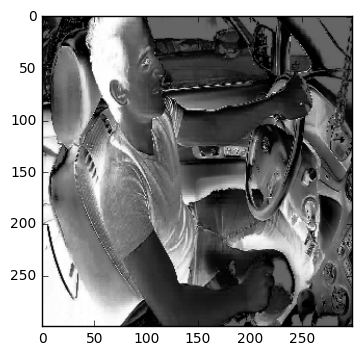

In [382]:
plt.imshow(S, cmap='gray')

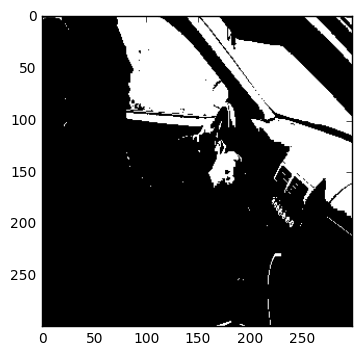

In [341]:
plt.imshow(k1 > 0.6, cmap='gray')

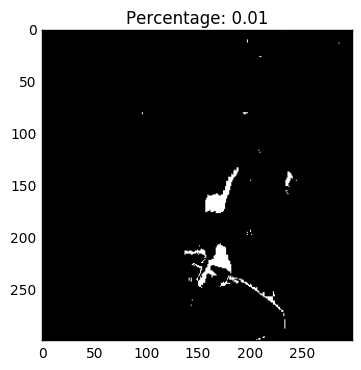

In [351]:
def plot_dec(f):
    a = fltrs[9]
    plt.imshow(a > f, cmap='gray')
    plt.title("Percentage: {:.2f}".format((a > f).astype(float).sum() / (299*299)))
    
widgets.interact(plot_dec, f=(0,1,0.001))

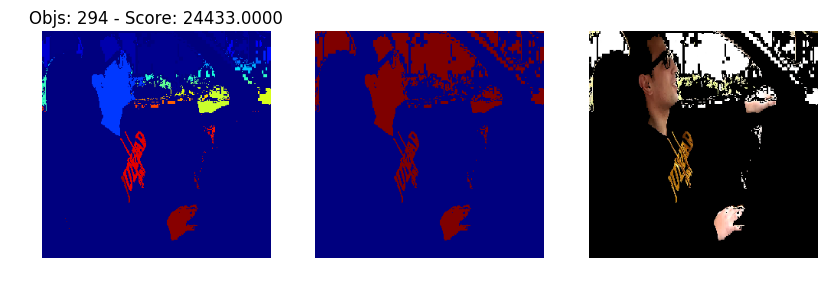

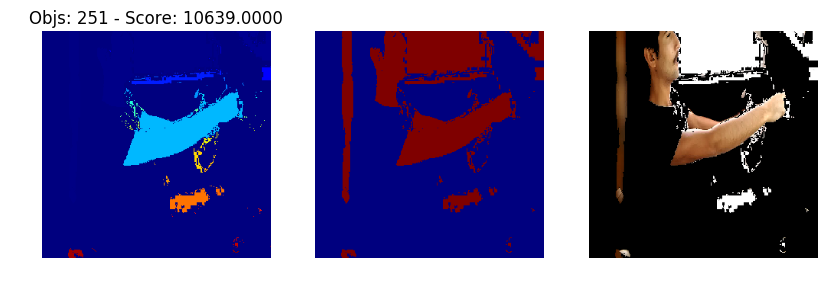

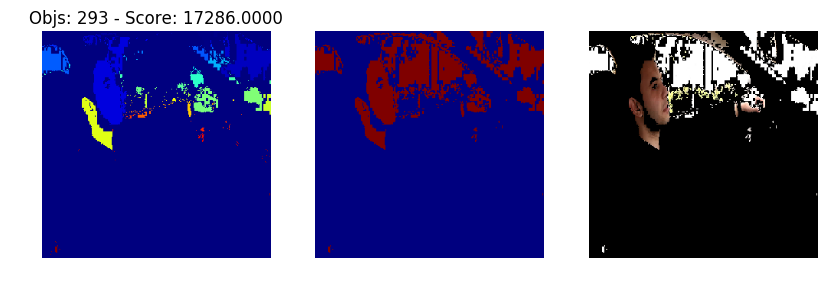

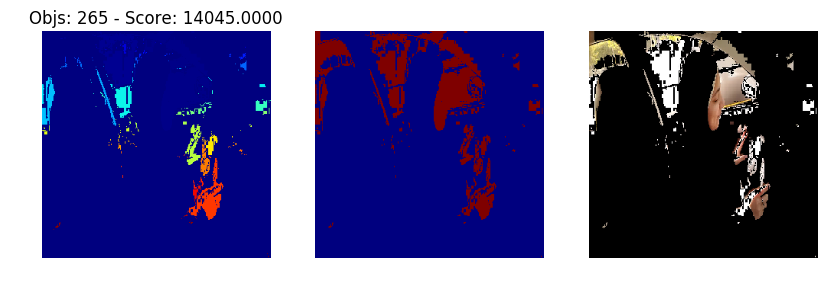

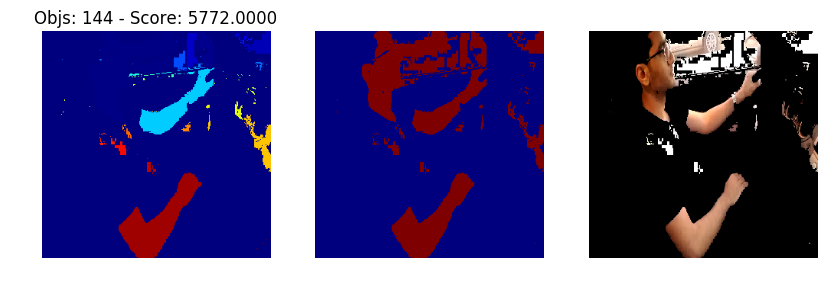

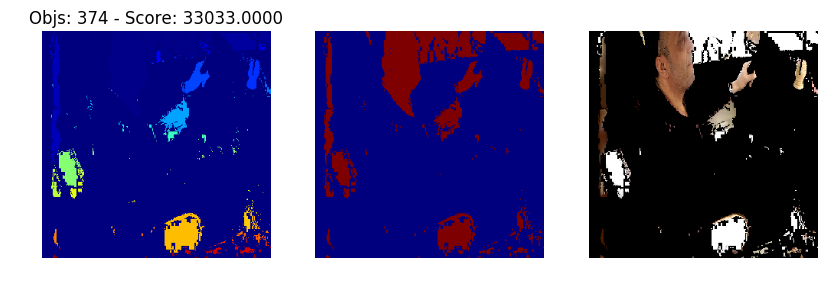

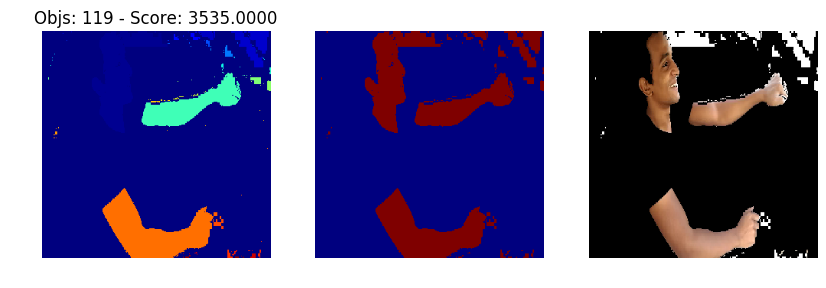

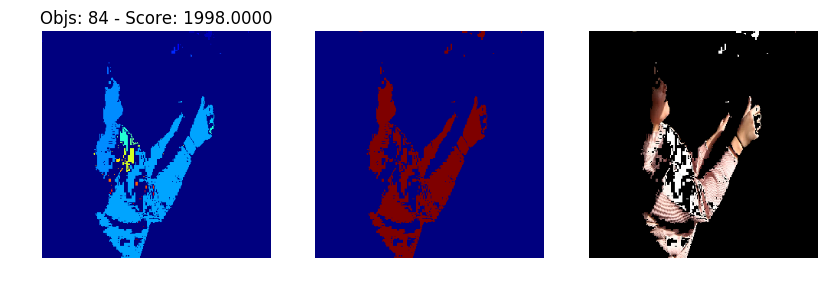

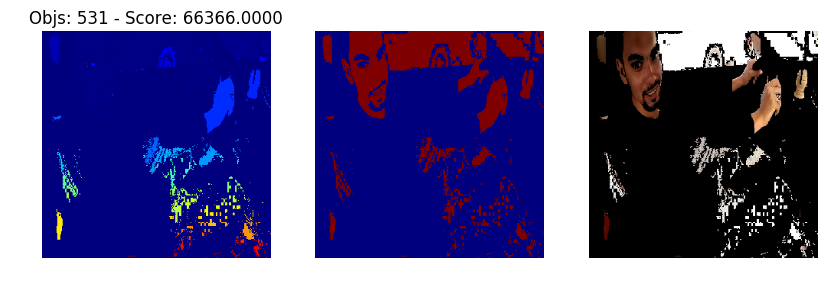

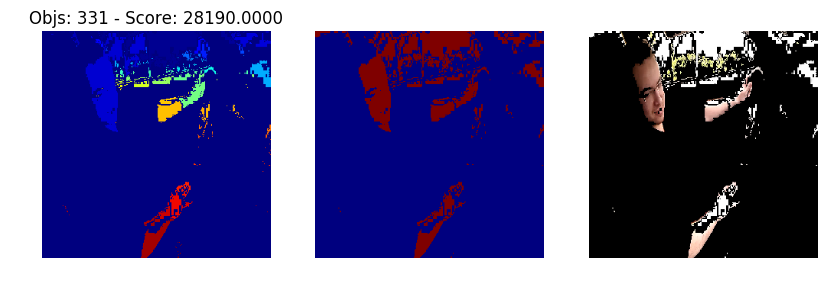

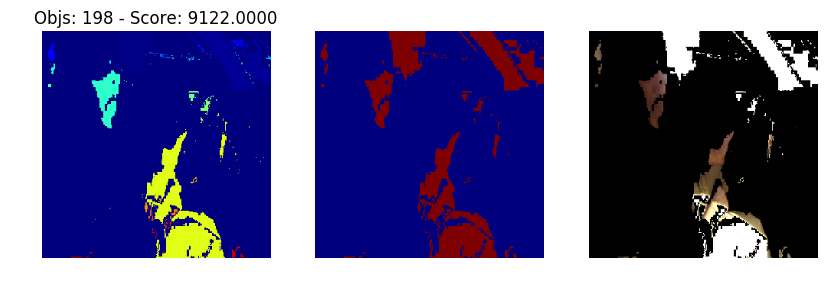

In [48]:
for idx in range(fltrs.shape[0]):
    lbl, nlbl, objs, main_objs, score, top_3_lbls, img_w_lbls = process_image(
        fltrs[idx], images[idx], 0.5
    )
    fig, axes = plt.subplots(1,3, figsize=(10,10))
    axes[0].set_title("Objs: {} - Score: {:.4f}".format(nlbl, score))
    axes[0].imshow(lbl)
    axes[0].axis('off')
    axes[1].imshow(top_3_lbls)
    axes[1].axis('off')
    axes[2].imshow(img_w_lbls)
    axes[2].axis('off')

In [ ]:
plt.imshow()

In [ ]:
def image_score(img):
    lbls, nlbls = label(img)

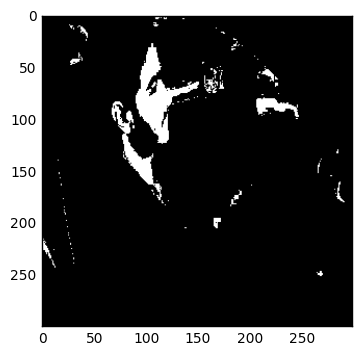

In [300]:
plt.imshow(fltrs[5]>0.97, cmap='gray')

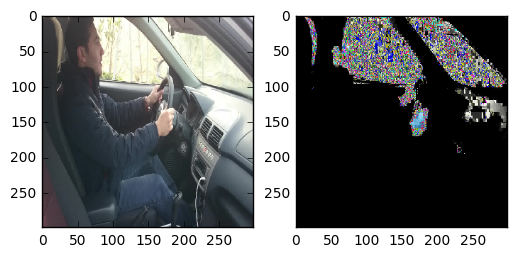

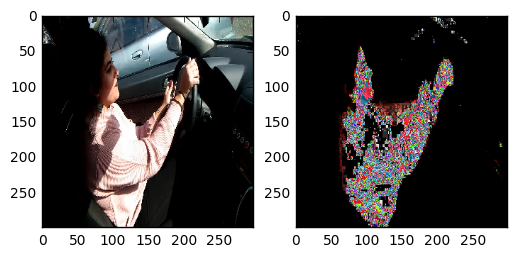

In [247]:
for i in range(2):
    plot_images(i)

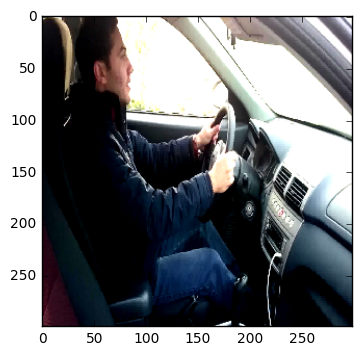

In [50]:
plt.imshow(images[1])

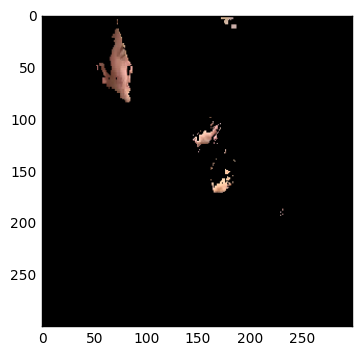

In [51]:
plt.imshow(img_filtered[1])

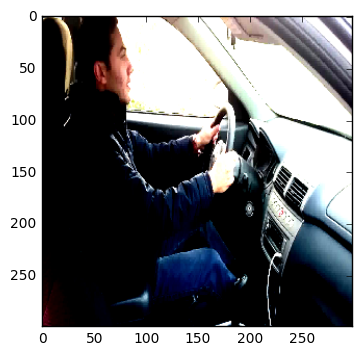

In [52]:
plt.imshow(images[2])

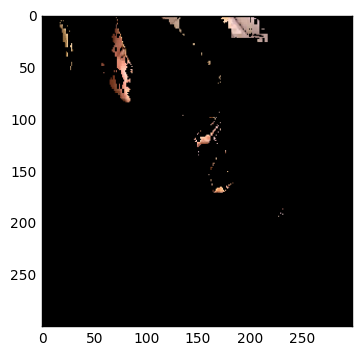

In [53]:
plt.imshow(img_filtered[2])

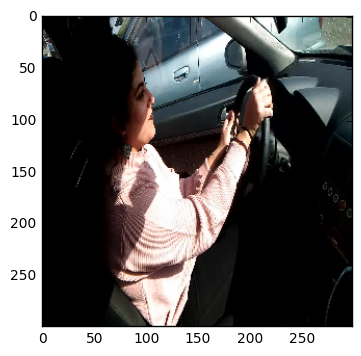

In [212]:
plt.imshow(_X[3])

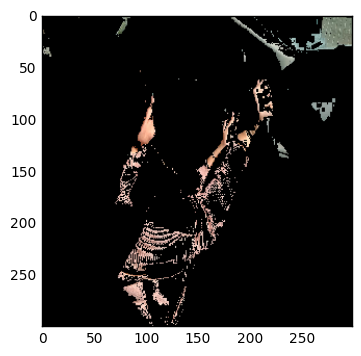

In [213]:
plt.imshow(img_filtered[3])

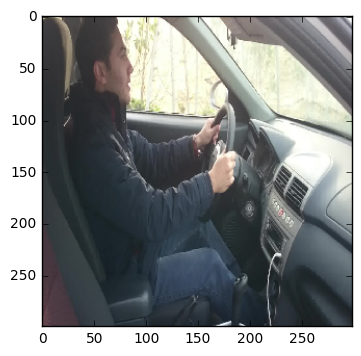

In [214]:
plt.imshow(_X[4])

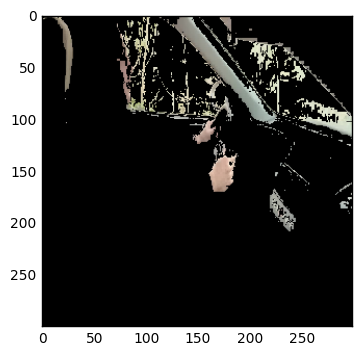

In [215]:
plt.imshow(img_filtered[4])

#### OpenCV Skin Segmentation

In [45]:
img1 = images[0]
img2 = imread('Faces-of-the-Future-1.jpg')
img3 = imread('HumanHeadphonesHP-1200x630-e1474323336782.jpg')

In [16]:
import cv2

In [38]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
profile_cascade = cv2.CascadeClassifier('haarcascade_profileface.xml')

In [46]:
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

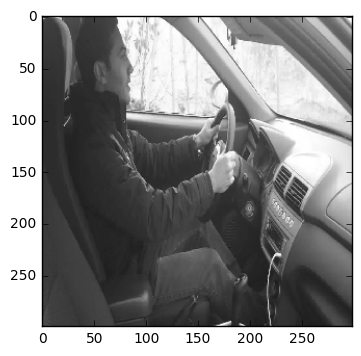

In [54]:
plt.imshow(gray, cmap='gray')

In [55]:
img = img1
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
profiles = profile_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    print(x,y,w,h)
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
for (x,y,w,h) in profiles:
    print(x,y,w,h)
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

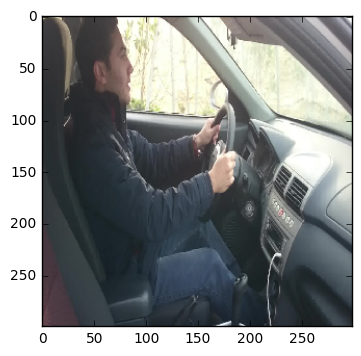

In [57]:
plt.imshow(img)

#### Logistic Regression Skin Segmentation Classifier

In [354]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.decomposition import PCA
import colorsys

In [355]:
model = LogisticRegression()
pca = PCA(n_components=2)

In [356]:
pca.fit(data[:, [2,1,0]])

PCA(copy=True, n_components=2, whiten=False)

In [357]:
X = pca.transform(data[:, [2,1,0]])

In [358]:
X = cl.rgb_to_hsv(data[:, [2,1,0]])
y = 2-data[:,3]

In [359]:
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [360]:
metrics.accuracy_score(model.predict(X), y)

0.96069485874714866

In [364]:
img_filter = model.predict_proba(cl.rgb_to_hsv(_X[-99]).reshape(-1, 3))[:,1].reshape(img.shape[:2])

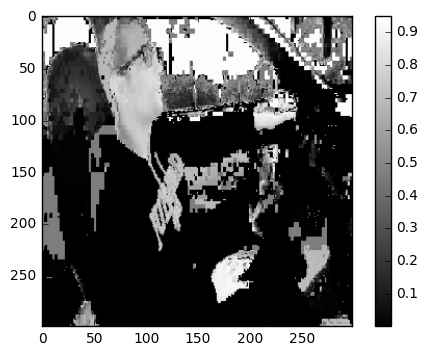

In [365]:
plt.imshow(img_filter, cmap='gray')
plt.colorbar()

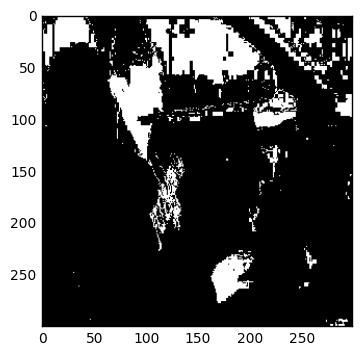

In [367]:
def plot_dec(f):
    plt.imshow(img_filter > f, cmap='gray')
    
widgets.interact(plot_dec, f=(0,1,0.01))

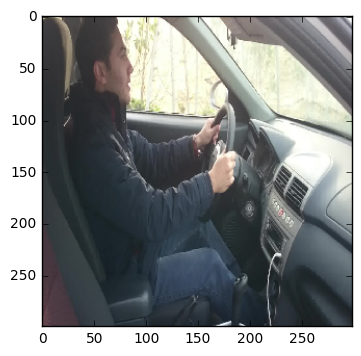

In [100]:
plt.imshow(img)

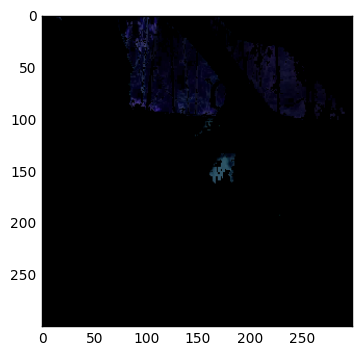

In [147]:
plt.imshow(img * np.repeat(img_filter.reshape(299, 299, 1), 3, axis=2).astype(int))

#### HSV Color Fixing

In [74]:
_X4_HSV = cl.rgb_to_hsv(_X[4])

In [10]:
from PIL import Image, ImageEnhance

In [11]:
img = Image.fromarray(_X[4])
_img = Image.fromarray(_X[3])

In [12]:
contrast = ImageEnhance.Contrast(img)
_contrast = ImageEnhance.Contrast(_img)